In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import print_function
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from scipy.stats import mode
from sklearn.metrics import f1_score

In [79]:
!ls ../tfhub/inference

inception_v3  mobilenet_v1_025_128  mobilenet_v2_100_128  nasnet_mobile


In [3]:
def draw_contour(mask, rgb):
    if rgb.shape[0] != mask.shape[0]:
        x_, y_ = mask.shape[:2]
        rgb = cv2.resize(rgb, dsize=(y_, x_))
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, 0, (0,0,0), 5)
    return rgb2

def draw_contour_all(mask, rgb):
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, -1, (0,0,0), 3)
    return rgb2

mask_list = glob.glob('../data/validation_svs/*png')
mask_paths = pd.DataFrame(mask_list, index=[os.path.basename(x).replace('.png', '') for x in mask_list])

# Evaluate performance

In [4]:
BACKGROUND = 255
def get_regions(mask, thresh=500):
#     label_images = {x: np.zeros_like(mask) for x in range(5)}
    label_images = []
    label_codes = []
    
    labels = np.unique(mask)
    image = (mask < BACKGROUND).astype(np.uint8)
    
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
    for cnt_num, _ in enumerate(contours):
        dummy_image = np.zeros_like(mask)
        cv2.drawContours(dummy_image, contours, cnt_num, 1, -1)
        ## Check area -- 
        pos_area = dummy_image.sum()
        if pos_area < thresh:
            continue
        dummy_image = dummy_image.astype(np.bool)
        cnt_label = mode(mask[dummy_image])[0][0]
        label_images.append(np.copy(dummy_image))
        label_codes.append(cnt_label)
        
    return label_images, label_codes

<Figure size 432x288 with 0 Axes>

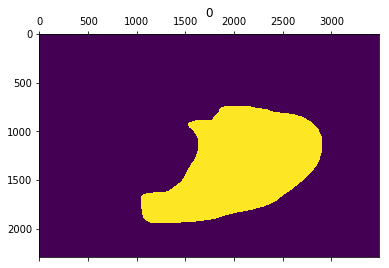

<Figure size 432x288 with 0 Axes>

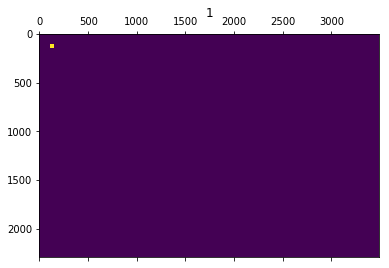

<Figure size 432x288 with 0 Axes>

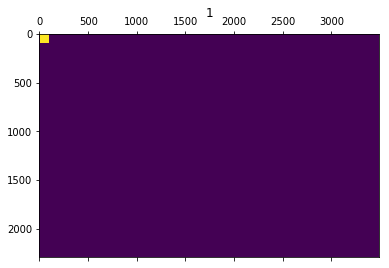

In [69]:
## Test for the get_regions function
np.unique(mask)
mask2 = np.copy(mask)
mask2[10:100, 10:100] = 1
mask2[110:150, 110:150] = 1
label_images, label_codes = get_regions(mask2)

for LI, LC in zip(label_images, label_codes): 
    plt.figure()
    plt.matshow(LI)
    plt.title(LC)

In [5]:
def perform_comparison(glob_path):
    inf_list = glob.glob(glob_path) # Where to glob for outputs
    print(len(inf_list))
    grade_dict = {0: 'G3', 1: 'G4', 2: 'G5', 3: 'BN', 4: 'ST'}
    attrib = ['Region', 'Slide', 'Region_area', 'TotalAcc', 'EpitheliumAcc', 
              'EpitheliumF1', 'Class_Label', 'Stroma_Area']
    attrib += ['{}'.format(x) for y,x in grade_dict.items()]
    performance = {k: [] for k in attrib}

    ## Reduce to slides we have annotated
    inf_bases = [os.path.basename(infp).replace('_prob.npy', '') for infp in inf_list]
    inf_list = [infp for infp, infb in zip(inf_list, inf_bases) if infb in mask_paths.index]
    print(len(inf_list))

    for idx, inf_path in enumerate(inf_list):
        inf_base = os.path.basename(inf_path).replace('_prob.npy', '')

        if inf_base not in mask_paths.index:
            print('{} no mask'.format(inf_base))
            continue

        mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
        x = np.load(inf_path)
        x_, y_ = x.shape[:2]
        mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
        label_images, label_codes = get_regions(mask)

        amax = np.argmax(x, axis=-1)
        amax[mask==255] = 255

        ## Loop over the present classes:
        region = 0
        for LI, LC in zip(label_images, label_codes):
            ## pull out annotated area
            amax_region = amax[LI]
            total_size = float(amax_region.shape[0])

            ## pull out non-stroma
            stroma_area = (amax_region == 4).sum()
            amax_region = amax_region[amax_region != 4]
            non_stroma_size = float(amax_region.shape[0])

            ## Reassign 2 --> 1 ( G5 / 4+5 --> G4 )
            amax_region[amax_region == 2] = 1

        #     ## Remove BN
        #     amax_region = amax_region[amax_region != 3]
            if LC == 2: LC = 1
            gt_region = np.zeros_like(amax_region) + LC
            total_acc = (amax_region == LC).sum() / total_size
            epithelium_acc = (amax_region == LC).sum() / non_stroma_size
            epithelium_f1 = f1_score(gt_region, amax_region, average='weighted')

            performance['Region'].append('{}_{:02d}'.format(inf_base, region))
            performance['Slide'].append(inf_base)
            performance['Region_area'].append(total_size)
            performance['TotalAcc'].append(total_acc)
            performance['EpitheliumAcc'].append(epithelium_acc)
            performance['EpitheliumF1'].append(epithelium_f1)
            performance['Class_Label'].append(grade_dict[LC])
            performance['Stroma_Area'].append(stroma_area)
            for co, gr in grade_dict.items():
                performance['{}'.format(gr)].append((amax_region == co).sum())
            print(idx, region, grade_dict[LC], inf_path, 'ACC:', epithelium_acc, 'F1:', epithelium_f1)
            region += 1


    perf_df = pd.DataFrame(performance, index=performance['Region'], columns=attrib[1:])
    outpath = os.path.join(os.path.split(inf_path)[0], 'processed_perf.csv')
    print(outpath)
    perf_df.to_csv(outpath, sep='\t')

In [9]:
!ls ../unet_small/*/inference

../unet_small/10x_FOV/inference:
1304700_prob.npy  1305458_prob.npy	  s10-5477-001_prob.npy
1304700_rgb.jpg   1305458_rgb.jpg	  s10-5477-001_rgb.jpg
1304701_prob.npy  1305459_prob.npy	  s10-586-000_color.jpg
1304701_rgb.jpg   1305459_rgb.jpg	  s10-586-000_prob.npy
1304702_prob.npy  1305460_prob.npy	  s10-586-000_rgb.jpg
1304702_rgb.jpg   1305460_rgb.jpg	  s10-6178-047_color.jpg
1304703_prob.npy  1305461_prob.npy	  s10-6178-047_prob.npy
1304703_rgb.jpg   1305461_rgb.jpg	  s10-6178-047_rgb.jpg
1304704_prob.npy  1305472_prob.npy	  s12_1823-012_color.jpg
1304704_rgb.jpg   1305472_rgb.jpg	  s12_1823-012_prob.npy
1304705_prob.npy  1305473_prob.npy	  s12_1823-012_rgb.jpg
1304705_rgb.jpg   1305473_rgb.jpg	  s12-1932-001_color.jpg
1304706_prob.npy  1305474_prob.npy	  s12-1932-001_prob.npy
1304706_rgb.jpg   1305474_rgb.jpg	  s12-1932-001_rgb.jpg
1304709_prob.npy  1305475_prob.npy	  s12-3216-004_color.jpg
1304709_rgb.jpg   1305475_rgb.jpg	  s12-3216-004_prob.npy
1304711_prob.npy  1305476_prob.npy

In [10]:
modelname = 'unet_small'
trainings = ['5x', '10x', '20x', '5x_FOV', '10x_FOV', '20x_FOV']
# trainings = ['10x_FOV', '20x_FOV']
glob_paths = ['../{}/{}/inference/*.npy'.format(modelname, tx) for tx in trainings]
# glob_paths = [
#     '../tfhub/inference/inception_v3/*.npy',
#     '../tfhub/inference/mobilenet_v2_050_224/*.npy',
#     '../tfhub/inference/nasnet_large/*.npy',
#     '../tfhub/inference/resnet_v2_152/*.npy',
# ]
for glob_path in glob_paths:
    print(glob_path)
    perform_comparison(glob_path)

../unet_small/5x/inference/*.npy
104
70
0 0 G4 ../unet_small/5x/inference/1305449_prob.npy ACC: 0.5568844473099792 F1: 0.715383146478439
1 0 G3 ../unet_small/5x/inference/1304700_prob.npy ACC: 0.9347953625865352 F1: 0.9662989488840329
2 0 G3 ../unet_small/5x/inference/1304706_prob.npy ACC: 0.8739590006406149 F1: 0.9327407913853516
2 1 G3 ../unet_small/5x/inference/1304706_prob.npy ACC: 0.9424180892933243 F1: 0.970355552687617
3 0 G4 ../unet_small/5x/inference/1305445_prob.npy ACC: 0.7677835944416644 F1: 0.8686398005454515
4 0 G4 ../unet_small/5x/inference/1305488_prob.npy ACC: 0.42969293628561744 F1: 0.6010982153999751
5 0 G3 ../unet_small/5x/inference/1304704_prob.npy ACC: 0.8254315761624446 F1: 0.9043686840322189
6 0 G4 ../unet_small/5x/inference/1305451_prob.npy ACC: 0.43883141356029504 F1: 0.6099830868641312
7 0 G3 ../unet_small/5x/inference/1304719_prob.npy ACC: 0.7235958485958486 F1: 0.8396351722305854
8 0 G4 ../unet_small/5x/inference/1305489_prob.npy ACC: 0.49513526929759244 F1

63 0 G4 ../unet_small/5x/inference/1305481_prob.npy ACC: 0.5584833182735915 F1: 0.7167010538069165
64 0 G4 ../unet_small/5x/inference/1305458_prob.npy ACC: 0.6430662098575783 F1: 0.7827635989341167
65 0 G4 ../unet_small/5x/inference/1305459_prob.npy ACC: 0.8345969537223179 F1: 0.909842297545471
66 0 G4 ../unet_small/5x/inference/1305482_prob.npy ACC: 0.30135389933483475 F1: 0.4631390423294797
67 0 G4 ../unet_small/5x/inference/1305478_prob.npy ACC: 0.5627727951191704 F1: 0.7202234347524021
68 0 G3 ../unet_small/5x/inference/1304729_prob.npy ACC: 0.5888813499484226 F1: 0.7412527687703534
69 0 G3 ../unet_small/5x/inference/1304732_prob.npy ACC: 0.8835841587431457 F1: 0.9381945103347361
../unet_small/5x/inference/processed_perf.csv
../unet_small/10x/inference/*.npy
104
70
0 0 G4 ../unet_small/10x/inference/1305449_prob.npy ACC: 0.6609644527314054 F1: 0.7958803111583388
1 0 G3 ../unet_small/10x/inference/1304700_prob.npy ACC: 0.7001781133279279 F1: 0.8236526606702395
2 0 G3 ../unet_small/1

55 0 G4 ../unet_small/10x/inference/1305495_prob.npy ACC: 0.42129366533881146 F1: 0.5928312714155135
56 0 G4 ../unet_small/10x/inference/1305453_prob.npy ACC: 0.4280797831567135 F1: 0.5995180216198568
57 0 G3 ../unet_small/10x/inference/1304703_prob.npy ACC: 0.8676914630798792 F1: 0.929159318048207
58 0 G3 ../unet_small/10x/inference/1304712_prob.npy ACC: 0.8326632873040843 F1: 0.9086920582437846
59 0 G3 ../unet_small/10x/inference/1304717_prob.npy ACC: 0.5146389925623607 F1: 0.6795533392306642
60 0 G3 ../unet_small/10x/inference/1304711_prob.npy ACC: 0.6687182074735539 F1: 0.8014752934061838
61 0 G4 ../unet_small/10x/inference/1305448_prob.npy ACC: 0.693031521654396 F1: 0.8186870862004738
62 0 G4 ../unet_small/10x/inference/1305447_prob.npy ACC: 0.45807141492107073 F1: 0.6283250741128716
63 0 G4 ../unet_small/10x/inference/1305481_prob.npy ACC: 0.7683085061999149 F1: 0.8689756380248439
64 0 G4 ../unet_small/10x/inference/1305458_prob.npy ACC: 0.47349078950844437 F1: 0.6426789945071874

47 0 G4 ../unet_small/20x/inference/1305457_prob.npy ACC: 0.2796685883027846 F1: 0.4370953399328291
48 0 G3 ../unet_small/20x/inference/1304715_prob.npy ACC: 0.7485127848321447 F1: 0.8561707884841128
49 0 G4 ../unet_small/20x/inference/1305493_prob.npy ACC: 0.24651248590851638 F1: 0.3955234924563898
50 0 G3 ../unet_small/20x/inference/1304721_prob.npy ACC: 0.829248168719311 F1: 0.9066546386648918
51 0 G4 ../unet_small/20x/inference/1305446_prob.npy ACC: 0.26749876604544176 F1: 0.42208919363295305
52 0 G3 ../unet_small/20x/inference/1304727_prob.npy ACC: 0.7574625264151849 F1: 0.8619956500127857
53 0 G4 ../unet_small/20x/inference/1305494_prob.npy ACC: 0.21573363828815245 F1: 0.35490280353173775
54 0 G3 ../unet_small/20x/inference/1304720_prob.npy ACC: 0.6774621247824256 F1: 0.8077227077425615
55 0 G4 ../unet_small/20x/inference/1305495_prob.npy ACC: 0.44014528992691976 F1: 0.6112512300050711
56 0 G4 ../unet_small/20x/inference/1305453_prob.npy ACC: 0.2468869176797792 F1: 0.396005305981

40 0 G3 ../unet_small/5x_FOV/inference/1304701_prob.npy ACC: 0.7558547188332632 F1: 0.8609535979554348
41 0 G4 ../unet_small/5x_FOV/inference/1305460_prob.npy ACC: 0.8002568989577005 F1: 0.8890474458628957
42 0 G4 ../unet_small/5x_FOV/inference/1305455_prob.npy ACC: 0.3747157967576117 F1: 0.545153838548174
43 0 G4 ../unet_small/5x_FOV/inference/1305473_prob.npy ACC: 0.3281795886756734 F1: 0.49417953938428
44 0 G3 ../unet_small/5x_FOV/inference/1304723_prob.npy ACC: 0.7000186428038777 F1: 0.823542313217603
45 0 G4 ../unet_small/5x_FOV/inference/1305484_prob.npy ACC: 0.23283276950185883 F1: 0.37771995563670446
46 0 G4 ../unet_small/5x_FOV/inference/1305454_prob.npy ACC: 0.2602925582138551 F1: 0.41306688120535084
47 0 G4 ../unet_small/5x_FOV/inference/1305457_prob.npy ACC: 0.34141176470588236 F1: 0.5090335028942291
48 0 G3 ../unet_small/5x_FOV/inference/1304715_prob.npy ACC: 0.6197887203504664 F1: 0.7652710659898477
49 0 G4 ../unet_small/5x_FOV/inference/1305493_prob.npy ACC: 0.6544758853

36 0 G4 ../unet_small/10x_FOV/inference/1305477_prob.npy ACC: 0.25193038106765725 F1: 0.40246707784630775
36 1 G4 ../unet_small/10x_FOV/inference/1305477_prob.npy ACC: 0.2466973462632832 F1: 0.39576140432592943
37 0 G4 ../unet_small/10x_FOV/inference/1305479_prob.npy ACC: 0.7726756213675975 F1: 0.8717619987028284
38 0 G3 ../unet_small/10x_FOV/inference/1304705_prob.npy ACC: 0.7749832042944825 F1: 0.8732287746942615
39 0 BN ../unet_small/10x_FOV/inference/1305490_prob.npy ACC: 0.6039752797728412 F1: 0.7530979902113923
39 1 G4 ../unet_small/10x_FOV/inference/1305490_prob.npy ACC: 0.9577222523990585 F1: 0.9784046242774567
39 2 G4 ../unet_small/10x_FOV/inference/1305490_prob.npy ACC: 0.8423668319810753 F1: 0.9144398578596731
39 3 G4 ../unet_small/10x_FOV/inference/1305490_prob.npy ACC: 0.98760671991187 F1: 0.9937647221837327
39 4 G4 ../unet_small/10x_FOV/inference/1305490_prob.npy ACC: 0.7362281222189261 F1: 0.8480776377219547
40 0 G3 ../unet_small/10x_FOV/inference/1304701_prob.npy ACC: 0

29 0 G3 ../unet_small/20x_FOV/inference/1304716_prob.npy ACC: 0.6472781394230046 F1: 0.785875953710802
30 0 G4 ../unet_small/20x_FOV/inference/1305498_prob.npy ACC: 0.38933665744567014 F1: 0.560464096817938
31 0 G4 ../unet_small/20x_FOV/inference/1305491_prob.npy ACC: 0.42168420208698226 F1: 0.593217820762114
32 0 G3 ../unet_small/20x_FOV/inference/1304726_prob.npy ACC: 0.7919459408878848 F1: 0.8838949019806773
33 0 G4 ../unet_small/20x_FOV/inference/1305450_prob.npy ACC: 0.3490253348245233 F1: 0.5174481543297678
34 0 G3 ../unet_small/20x_FOV/inference/1304730_prob.npy ACC: 0.6792752532737485 F1: 0.809010020185197
34 1 G3 ../unet_small/20x_FOV/inference/1304730_prob.npy ACC: 0.7098484693981604 F1: 0.8303057049821682
35 0 G3 ../unet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.7121284755512943 F1: 0.8318633627327454
35 1 G3 ../unet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.8381349507202426 F1: 0.9119406063105794
35 2 G3 ../unet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.67

In [34]:
perf_df = pd.DataFrame(performance, index=performance['Region'], columns=attrib[1:])
print(np.mean(perf_df.EpitheliumF1))
print(np.std(perf_df.EpitheliumF1))
perf_df

0.7336470977624209
0.23923788577288946


,Slide,Region_area,TotalAcc,EpitheliumAcc,EpitheliumF1,Class_Label,Stroma_Area,G3,G4,G5,BN,ST
1305449_00,1305449,2734606.0,0.284266,0.556884,0.715383,G4,1338706,465372,777355,0,153173,0
1304700_00,1304700,449236.0,0.549760,0.934795,0.966299,G3,185037,246972,3923,0,13303,0
1304706_00,1304706,25685.0,0.424917,0.873959,0.932741,G3,13197,10914,252,0,1322,0
1304706_01,1304706,132537.0,0.567298,0.942418,0.970356,G3,52755,75188,2074,0,2520,0
1305445_00,1305445,219890.0,0.362841,0.767784,0.868640,G4,115974,20407,79785,0,3724,0
1305488_00,1305488,295444.0,0.326058,0.429693,0.601098,G4,71256,121554,96332,0,6302,0
1304704_00,1304704,530954.0,0.470086,0.825432,0.904369,G3,228574,249594,51197,0,1589,0
1305451_00,1305451,389312.0,0.180647,0.438831,0.609983,G4,229050,87453,70328,0,2481,0
1304719_00,1304719,57825.0,0.245966,0.723596,0.839635,G3,38169,14223,2473,0,2960,0
1305489_00,1305489,381674.0,0.313603,0.495135,0.662328,G4,139934,37788,119694,0,84258,0


In [11]:
perf_tables = glob.glob('../unet_small/*/inference/processed_perf.csv')
# perf_tables = glob.glob('../tfhub/inference/*/processed_perf.csv')
print(perf_tables)

for perf_tab in sorted(perf_tables):
    df = pd.read_csv(perf_tab, sep='\t', header=0, index_col=0)
    basename = os.path.split(perf_tab)[0]
    print(basename, df.shape, np.mean(df['EpitheliumF1']))

['../unet_small/20x_FOV/inference/processed_perf.csv', '../unet_small/10x_FOV/inference/processed_perf.csv', '../unet_small/20x/inference/processed_perf.csv', '../unet_small/5x/inference/processed_perf.csv', '../unet_small/10x/inference/processed_perf.csv', '../unet_small/5x_FOV/inference/processed_perf.csv']
../unet_small/10x/inference (90, 12) 0.6923051459305362
../unet_small/10x_FOV/inference (90, 12) 0.7552497896651518
../unet_small/20x/inference (90, 12) 0.6262452028121803
../unet_small/20x_FOV/inference (90, 12) 0.6476386324175555
../unet_small/5x/inference (90, 12) 0.7336470977624209
../unet_small/5x_FOV/inference (90, 12) 0.8025316091526774


In [29]:
df

,Slide,Region_area,TotalAcc,EpitheliumAcc,EpitheliumF1,Class_Label,Stroma_Area,G3,G4,G5,BN,ST
1304727_00,1304727,1222425.0,0.143167,0.337213,0.504352,G3,703433,175011,209407,0,134574,0
1305455_00,1305455,761694.0,0.277718,0.786601,0.880556,G4,492770,30128,211536,0,27260,0
1304700_00,1304700,449236.0,0.119169,0.665502,0.799161,G3,368793,53535,19590,0,7317,0
1305496_00,1305496,366869.0,0.418452,0.891106,0.942418,G4,194592,8946,153517,0,9814,0
1304718_00,1304718,41426.0,0.088399,0.227171,0.370236,G3,25306,3662,10647,0,1811,0
1305495_00,1305495,1785940.0,0.500418,0.942219,0.970250,G4,837417,19643,893716,0,35164,0
1304728_00,1304728,28796.0,0.074837,0.201515,0.335435,G3,18102,2155,6488,0,2051,0
1304728_01,1304728,16164.0,0.479770,0.758435,0.862625,G3,5939,7755,1890,0,580,0
1304728_02,1304728,52932.0,0.149248,0.406797,0.578331,G3,33512,7900,10350,0,1170,0
1304728_03,1304728,64633.0,0.033156,0.067682,0.126782,G3,32970,2143,24056,0,5464,0


# Plot performance

Text(0.5,1,'F1 \n U-Net-Small 5X Combined HighGrade')

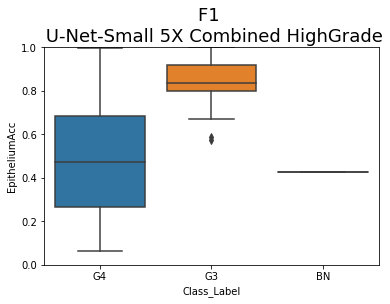

In [36]:
sns.boxplot(x="Class_Label", y="EpitheliumAcc", data=perf_df)
plt.ylim([0, 1.])

plt.title('F1 \n U-Net-Small 5X Combined HighGrade', fontsize=18)


# Draw masks into a figure

31
../tfhub/inference/inception_v3/1304732_prob.npy 1304732
(76, 116) [  0 255]
(76, 116) (76, 116, 3)


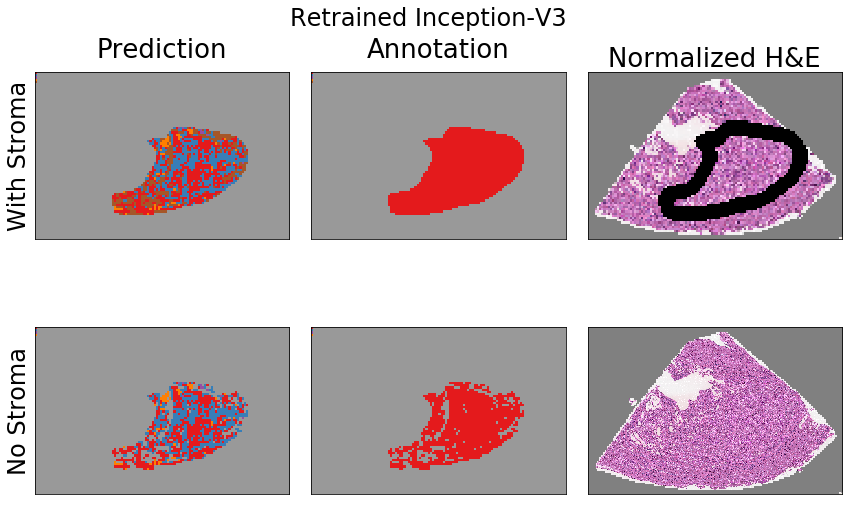

In [115]:
inf_list = glob.glob('../tfhub/inference/inception_v3/*npy')

# inf_list = glob.glob('../unet/10x/inference/*npy')

rgb_list = glob.glob('../unet/10x/inference/*rgb.jpg')

rgb_paths = pd.DataFrame(rgb_list, index=[os.path.basename(x).replace('_rgb.jpg', '') for x in rgb_list])
print(len(inf_list))

# inf_path = np.random.choice(inf_list,1)[0]
inf_path = '../tfhub/inference/inception_v3/1304732_prob.npy'
inf_base = os.path.basename(inf_path).replace('_prob.npy', '')
print(inf_path, inf_base)

x = np.load(inf_path)
mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
rgb = cv2.imread(rgb_paths.loc[inf_base,0], -1)[:,:,::-1]
x_, y_ = x.shape[:2]
mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
print(mask.shape, np.unique(mask))

fig, axs = plt.subplots(2,3,figsize=(12, 8))
    
amax = np.argmax(x, axis=-1)
## Take away unannotated area
amax[mask==255] = 6
mask[mask==255] = 6

mask[0:5, 0] = np.arange(5)
amax[0:5, 0] = np.arange(5)

axs[0][0].matshow(amax, cmap='Set1')
axs[0][0].set_yticks([])
axs[0][0].set_xticks([])
axs[0][0].set_title('Prediction', fontsize=26)
axs[0][0].set_ylabel('With Stroma', fontsize=24)

axs[0][1].matshow(mask, cmap='Set1')
axs[0][1].set_yticks([])
axs[0][1].set_xticks([])
axs[0][1].set_title('Annotation', fontsize=26)

rgb_marked = draw_contour(mask, rgb)
axs[0][2].imshow(rgb_marked)
axs[0][2].set_yticks([])
axs[0][2].set_xticks([])
axs[0][2].set_title('Normalized H&E', fontsize=26)

## Take away stroma
mask[amax==4] = 6
amax[amax==4] = 6

# rgb_marked = draw_contour_all(mask, rgb)

axs[1][0].matshow(amax, cmap='Set1')
axs[1][0].set_yticks([])
axs[1][0].set_xticks([])
axs[1][0].set_ylabel('No Stroma', fontsize=24)

axs[1][1].matshow(mask, cmap='Set1')
axs[1][1].set_yticks([])
axs[1][1].set_xticks([])

axs[1][2].imshow(rgb)
axs[1][2].set_yticks([])
axs[1][2].set_xticks([])

plt.tight_layout()
plt.suptitle('Retrained Inception-V3', fontsize=24)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/wsi_pred_label_inception_v3.pdf', bbox_inches='tight')